<a href="https://colab.research.google.com/github/jaisal2000/-Fine-Tuning-BERT-on-Kaggle-Hate-Speech-Dataset/blob/main/Code_FineTuning_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install datasets
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

# Set seed for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check if GPU is available and print device info
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
# Define the path to your dataset CSV file
data_path = "kaggle_hate_speech.csv"  # Update this path as necessary

# Load the dataset using pandas
df = pd.read_csv(data_path)

# Display the first few rows to confirm it's loaded correctly
print("Dataset sample:")
print(df.head())

# Check the distribution of labels (assuming binary classification with 0 and 1 labels)
print("\nLabel distribution:")
print(df['label'].value_counts())

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Convert the pandas DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into a DatasetDict for easier handling
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# Verify the dataset
print("\nDataset structure:")
print(dataset)


Dataset sample:
   Unnamed: 0  count  hate_speech  offensive_language  neither  label  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  

Label distribution:
label
1    19190
2     4163
0     1430
Name: count, dtype: int64

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_langua

In [4]:
# Load the pre-trained BERT tokenizer from Hugging Face (using the 'bert-base-uncased' model)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define a function to tokenize the input texts
def tokenize_function(examples):
    return tokenizer(examples["tweet"], truncation=True, padding="max_length", max_length=128)

# Apply the tokenization function to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# For model training, we need to set the format for PyTorch tensors
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Display a sample from the tokenized dataset
print("Sample tokenized data:")
print(tokenized_datasets["train"][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Sample tokenized data:
{'label': tensor(1), 'input_ids': tensor([  101,  3331, 10413,  2003,  1037,  7570,  2063,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
       

In [5]:

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define the number of labels. Adjust if your task has more than two classes.
num_labels = len(df['label'].unique())

# Load the pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)

# Define a compute_metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    # For additional evaluation, you can compute precision, recall, fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": fscore}

# Setup training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # Adjust the number of training epochs
    per_device_train_batch_size=16,  # Training batch size per device
    per_device_eval_batch_size=64,   # Evaluation batch size per device
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save checkpoint at the end of each epoch
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,     # Load the best model when finished training
    metric_for_best_model="accuracy",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)
print("Model and Trainer are set up!")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Model and Trainer are set up!


In [6]:
# Start training the model
trainer.train()

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

print("\nEvaluation Results:")
print(eval_results)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jaisalsharma2000 (jaisalsharma2000-tribhuvan-university-institute-of-engin) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.239500,0.239214,0.917087,0.910053,0.917087,0.912656
2,0.234100,0.245720,0.917289,0.907691,0.917289,0.911007
3,0.114000,0.262888,0.919911,0.914817,0.919911,0.916914



Evaluation Results:
{'eval_loss': 0.26288825273513794, 'eval_accuracy': 0.9199112366350616, 'eval_precision': 0.9148168916466032, 'eval_recall': 0.9199112366350616, 'eval_f1': 0.9169144108126517, 'eval_runtime': 33.6913, 'eval_samples_per_second': 147.13, 'eval_steps_per_second': 2.315, 'epoch': 3.0}


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the logs from the trainer state
logs = trainer.state.log_history

# Convert to DataFrame for easier plotting
df = pd.DataFrame(logs)
df = df.dropna(axis=1, how='all')  # Drop empty columns
df.head()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.6867,7.759026,0.000020,0.040323,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.4340,12.394032,0.000019,0.080645,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.2979,15.859381,0.000019,0.120968,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.2855,9.556152,0.000019,0.161290,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.3438,5.849362,0.000019,0.201613,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


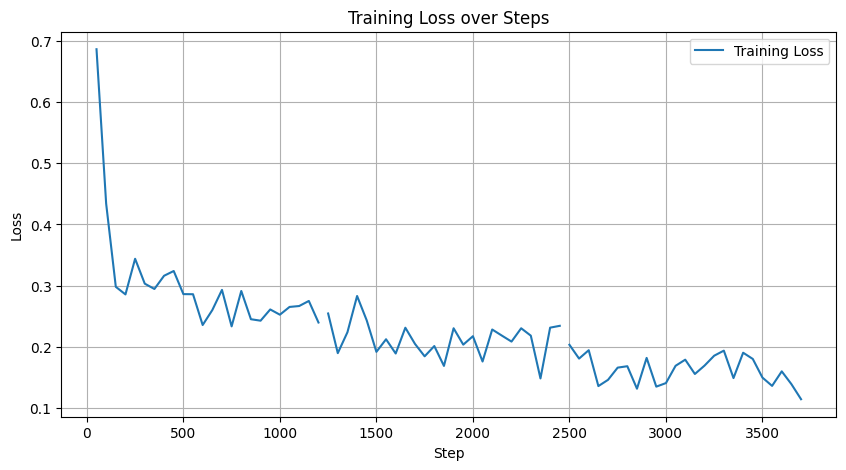

In [11]:
# Plot training loss over steps
plt.figure(figsize=(10, 5))
if 'loss' in df.columns:
    plt.plot(df["step"], df["loss"], label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()


In [12]:
output_dir = "./saved_model"

# Save model
model.save_pretrained(output_dir)

# Save tokenizer
tokenizer.save_pretrained(output_dir)


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [16]:
!pip install streamlit pyngrok
